In [1]:
# Import libraries we'll need
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import IncrementalPCA
import os


In [3]:
# Set the dataset path and image size
dataset_path = "fruits-360_100x100/fruits-360/Training"
img_size = (100, 100)
batch_size = 52  # Should be equal or more than n_components for PCA

# Create image generator and split into training and validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load training images
train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    subset="training",
    class_mode="sparse",  # using sparse labels since we don't one-hot encode
    shuffle=False
)

# Load validation images
val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    subset="validation",
    class_mode="sparse",
    shuffle=False
)
# Get the number of classes and samples
num_classes = train_gen.num_classes
num_samples = train_gen.samples # Number of samples in the training set
print(f"Number of classes: {num_classes}")  

Found 69293 images belonging to 170 classes.
Found 17261 images belonging to 170 classes.
Number of classes: 170


In [5]:
# Create PCA object with 50 components
pca = IncrementalPCA(n_components=50)

# Go through all batches and fit PCA on training images
batch_count = len(train_gen)

for i in range(batch_count):
    batch_X, _ = next(train_gen)  # get batch images only
    batch_X = batch_X.reshape(batch_X.shape[0], -1)  # flatten the images
    pca.partial_fit(batch_X)  # update PCA with this batch
    print(f"Fitting PCA batch {i+1}/{batch_count}", end="\r")

# Now we can transform the training and validation images
        



In [6]:
import csv

# Function to save reduced PCA features to CSV
def save_batches_to_csv(generator, csv_file):
    with open(csv_file, "w", newline="") as file:
        writer = csv.writer(file)
        for i in range(len(generator)):
            batch_X, batch_y = next(generator)
            batch_X = batch_X.reshape(batch_X.shape[0], -1)
            batch_X_pca = pca.transform(batch_X)  # apply PCA
            for x, y in zip(batch_X_pca, batch_y):
                writer.writerow(np.append(x, y))  # save features + label
            print(f"Saved batch {i+1}/{len(generator)} to {csv_file}", end="\r")

# Save PCA-transformed features to CSV files
save_batches_to_csv(train_gen, "fruit_pca_train.csv")
save_batches_to_csv(val_gen, "fruit_pca_val.csv")


In [7]:
# Load necessary libraries for model training
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load preprocessed PCA data from CSV
train_data = np.loadtxt("fruit_pca_train.csv", delimiter=",")
val_data = np.loadtxt("fruit_pca_val.csv", delimiter=",")

# Split data into X and y
X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_val = val_data[:, :-1]
y_val = val_data[:, -1]

# Get number of features after PCA
input_dim = X_train.shape[1]
# Define the model architecture

# Create a simple ANN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),  # input layer with PCA size
    tf.keras.layers.Dense(128, activation='relu'),  # hidden layer 1
    tf.keras.layers.Dense(64, activation='relu'),   # hidden layer 2
    tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')  # output layer
])

# Compile the model with Adam optimizer and classification loss
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
# Save the model
model.save("fruit_model.h5")


Epoch 1/10
2166/2166 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6435 - loss: 1.6928 - val_accuracy: 0.8584 - val_loss: 0.5738
Epoch 2/10
2166/2166 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9925 - loss: 0.0398 - val_accuracy: 0.8449 - val_loss: 0.6720
Epoch 3/10
2166/2166 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9947 - loss: 0.0250 - val_accuracy: 0.8544 - val_loss: 0.7302
Epoch 4/10
2166/2166 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9948 - loss: 0.0192 - val_accuracy: 0.8516 - val_loss: 0.8559
Epoch 5/10
2166/2166 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9949 - loss: 0.0191 - val_accuracy: 0.8559 - val_loss: 0.8998
Epoch 6/10
2166/2166 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9969 - loss: 0.0125 - val_accuracy: 0.8544 - val_loss: 0.9019
Epoch 7/10
2166/2166 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9981 - loss: 0.0077 - val_accuracy: 0.8737 - val_loss: 0.9327
Epoch 8/10
2166/2166 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9973 - loss: 0.0096 -

In [8]:
!pip install seaborn


540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Found 17261 images belonging to 170 classes.


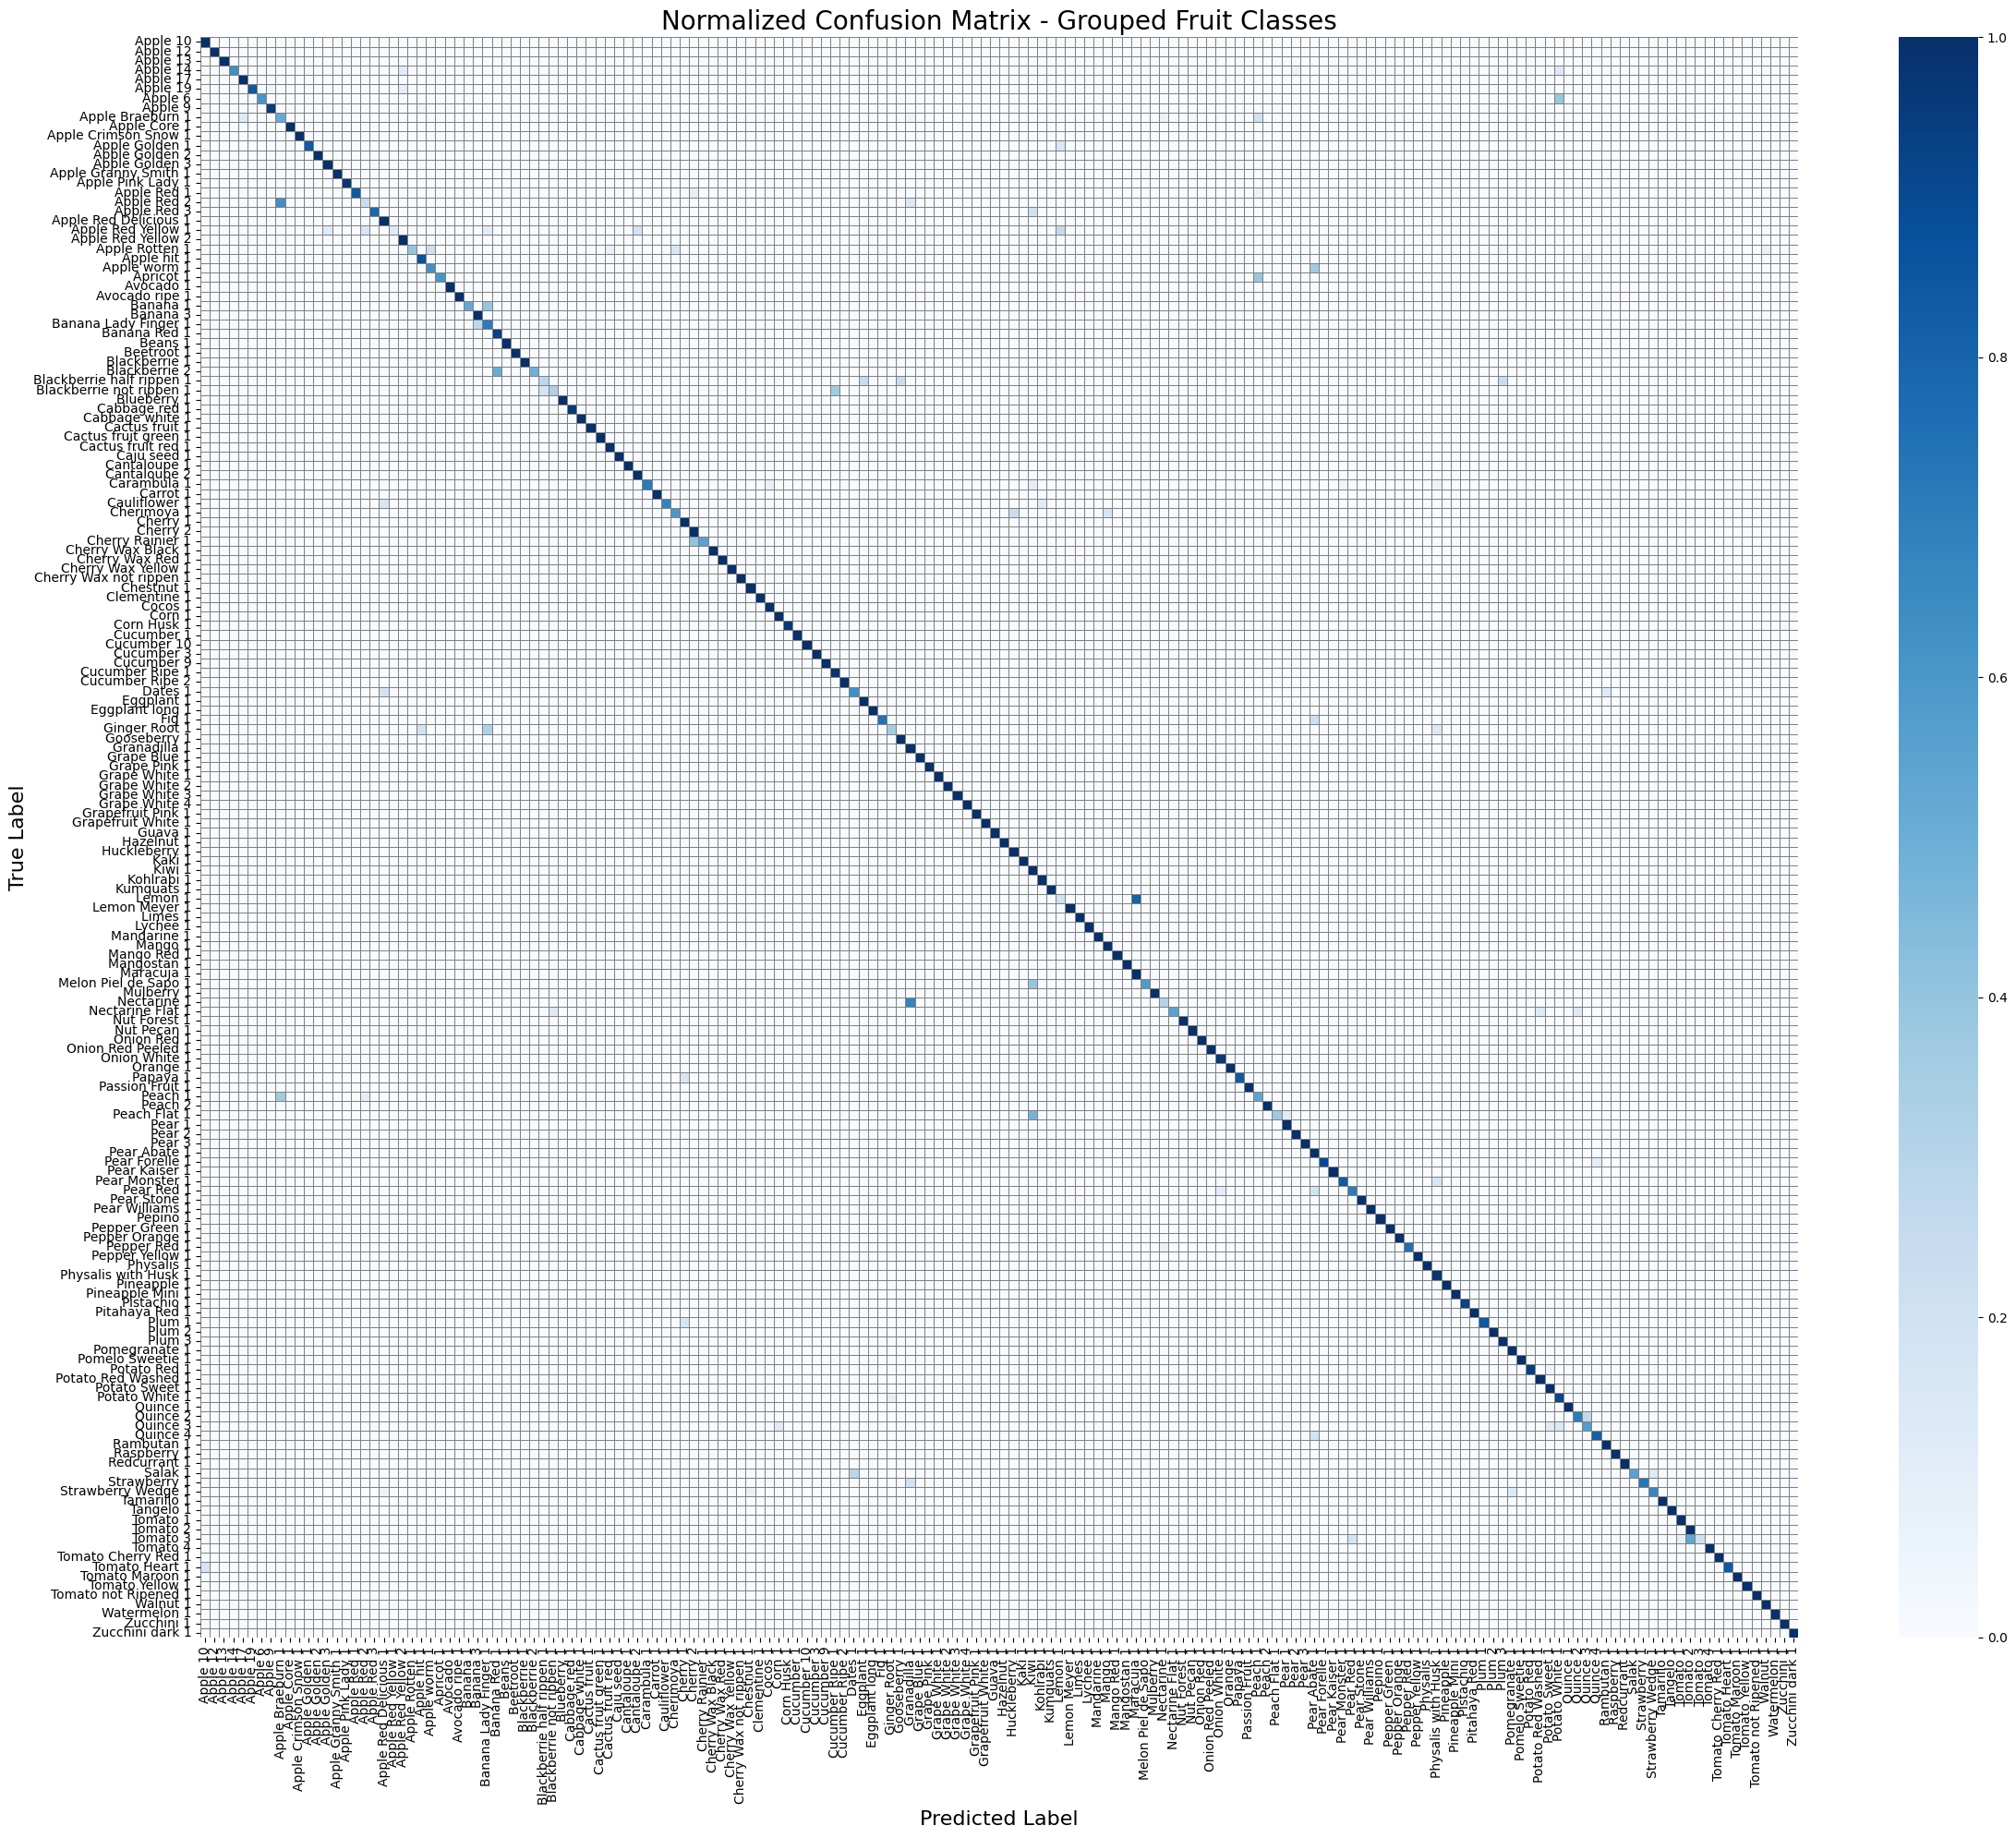

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# setting the path and image size
dataset_path = "fruits-360_100x100/fruits-360/Training"
img_size = (100, 100)

# getting predictions from the model
y_pred_probs = model.predict(X_val)  # get prediction probabilities
y_pred_grouped = np.argmax(y_pred_probs, axis=1)  # pick the class with highest score
y_val_grouped = y_val.astype(int)  # make sure true labels are int

# reload the validation data generator to get class names
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=1,  # loading one image at a time
    subset="validation",
    class_mode="sparse",
    shuffle=False  # keep order same
)

# mapping label index to actual class names
index_to_class = {v: k for k, v in val_gen.class_indices.items()}

# converting numeric predictions to class name strings
y_val_labels = [index_to_class[int(i)] for i in y_val_grouped]
y_pred_labels = [index_to_class[int(i)] for i in y_pred_grouped]

# creating the confusion matrix
class_names = sorted(list(set(y_val_labels) | set(y_pred_labels)))  # get all class names
cm = confusion_matrix(y_val_labels, y_pred_labels, labels=class_names)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # normalize by row

# plotting the confusion matrix
plt.figure(figsize=(24, 20))
sns.heatmap(cm_percent, annot=False, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            linewidths=0.5, linecolor='gray')

plt.title("Normalized Confusion Matrix - Grouped Fruit Classes", fontsize=20)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.xticks(rotation=90, ha='center', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# save the plot and show it
plt.savefig("grouped_confusion_matrix_named.png", dpi=300)
plt.show()


540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Found 17261 images belonging to 170 classes.


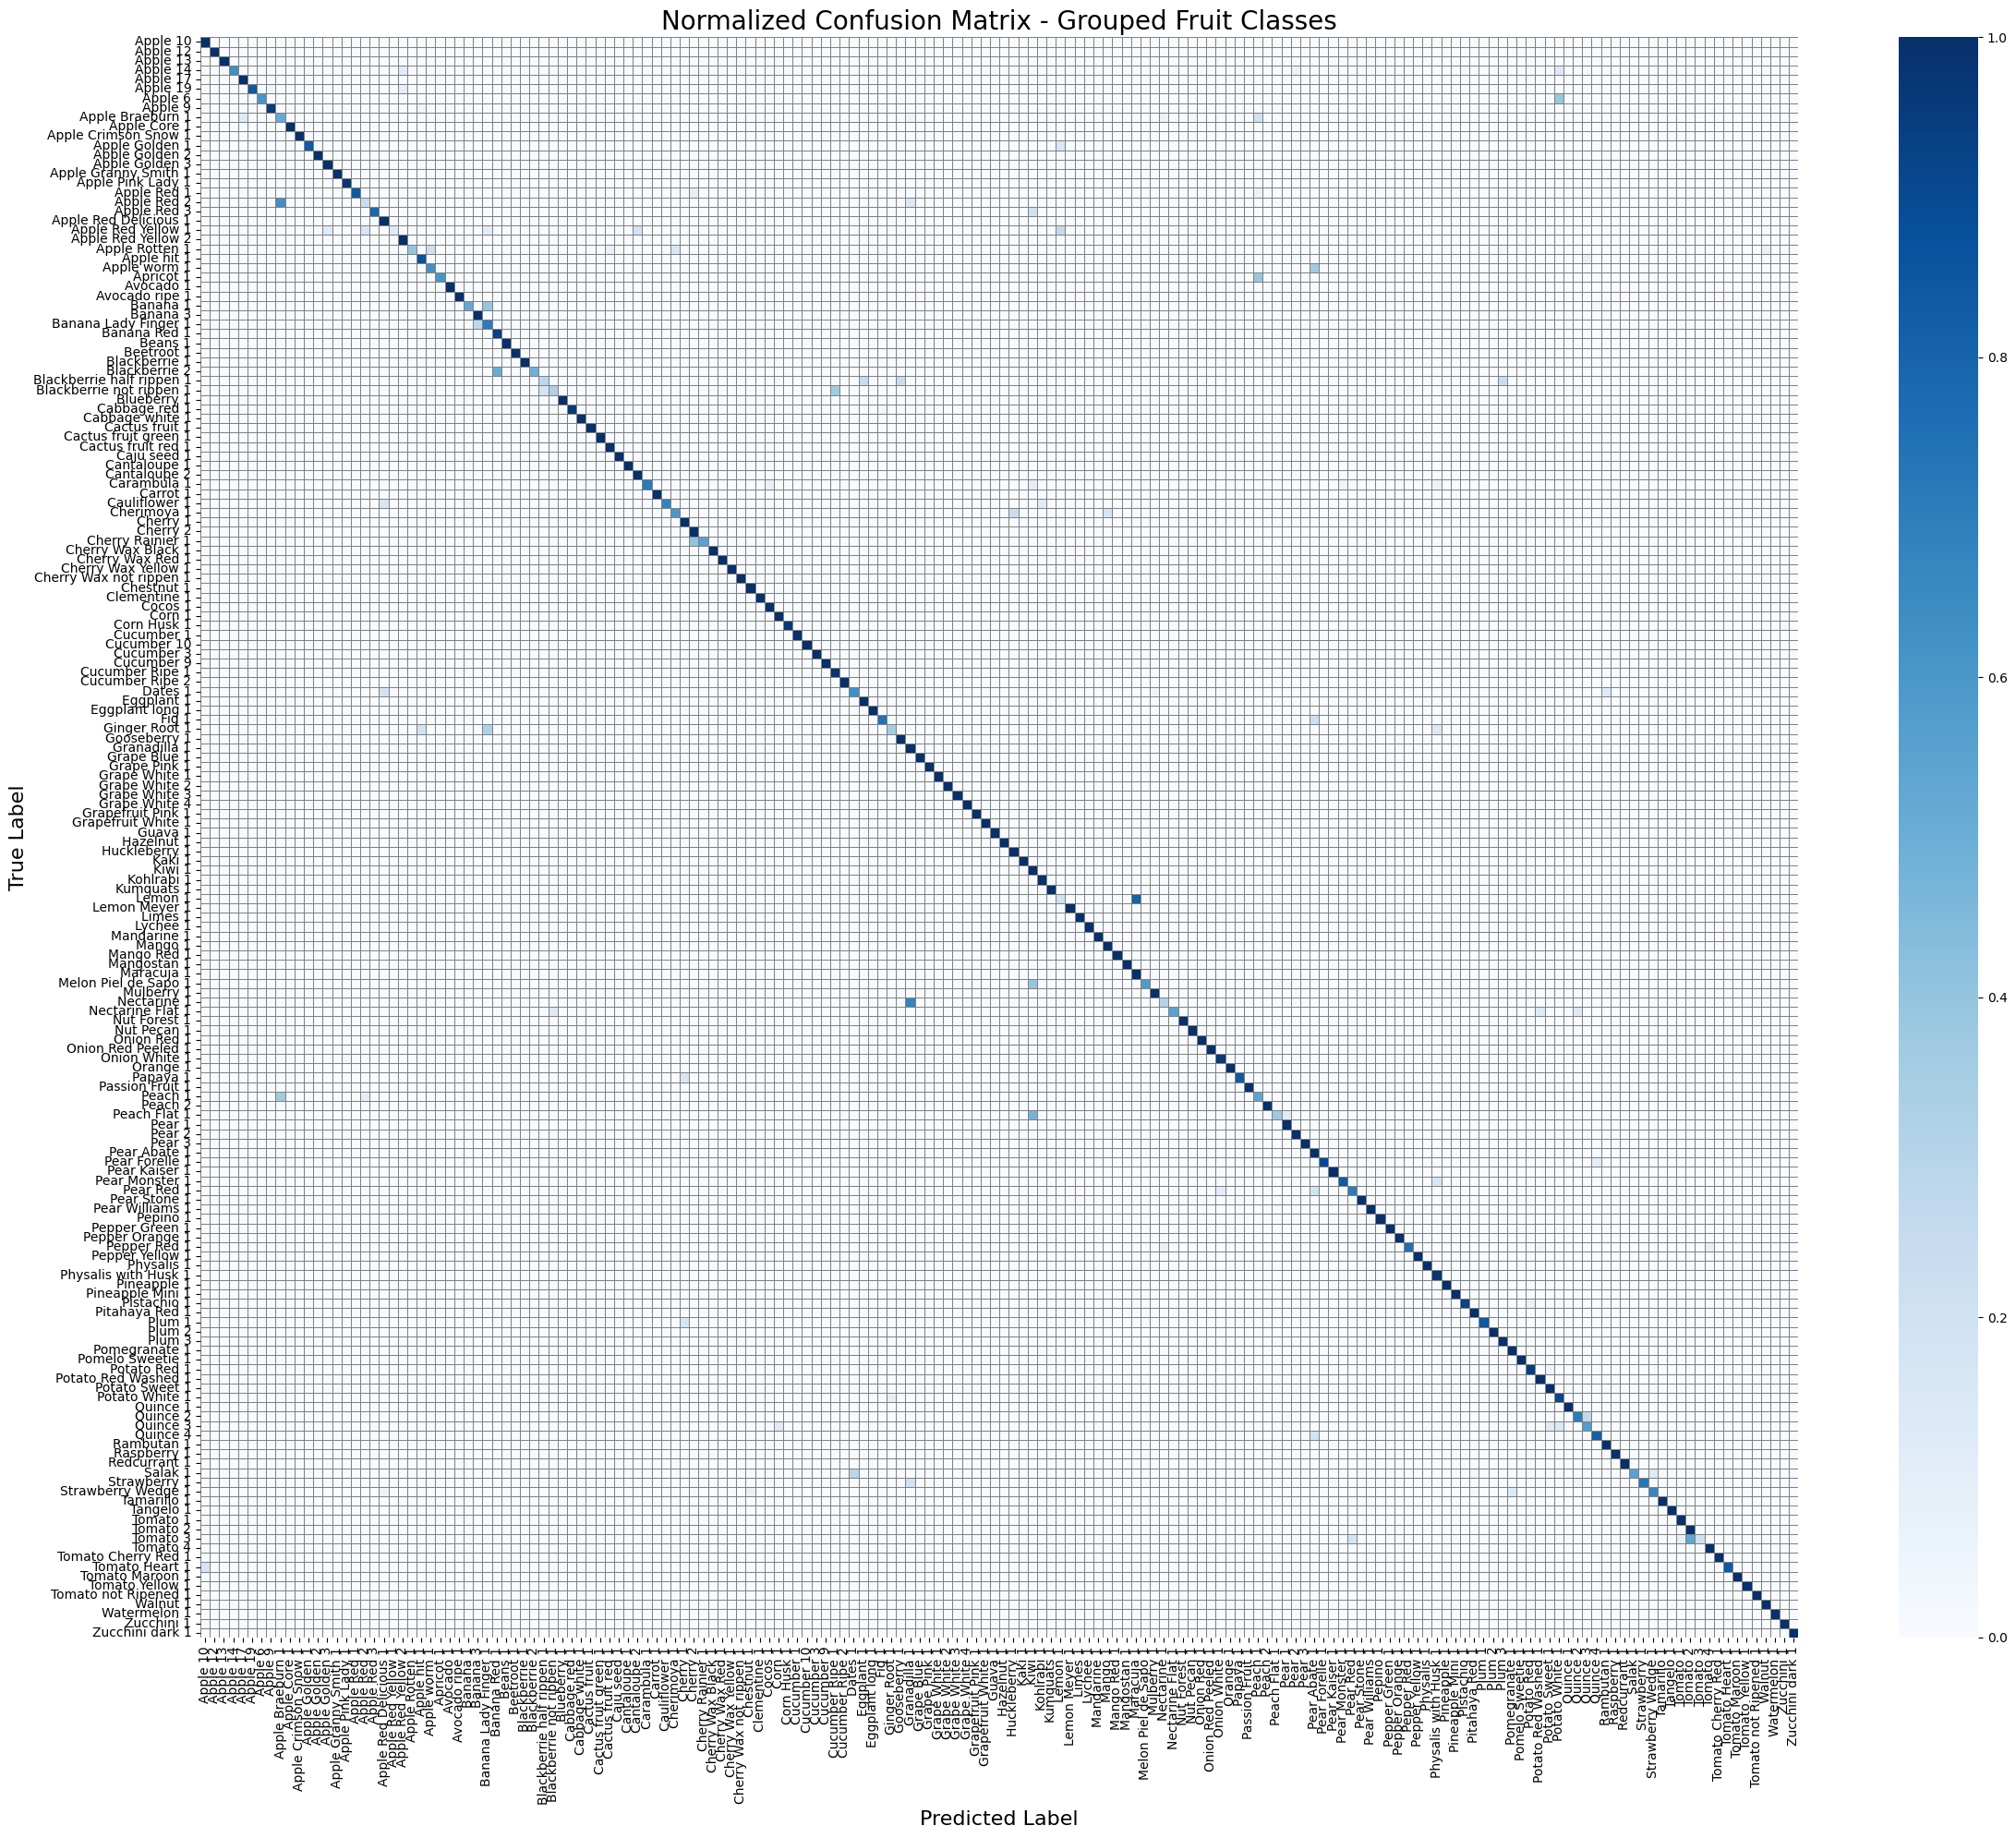

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the path where images are stored and define image size
dataset_path = "fruits-360_100x100/fruits-360/Training"
img_size = (100, 100)

# get predictions from the model using the validation data
y_pred_probs = model.predict(X_val)  # get prediction scores for each class
y_pred_grouped = np.argmax(y_pred_probs, axis=1)  # take the class with highest score
y_val_grouped = y_val.astype(int)  # convert true labels to integer type

# reload the validation data generator to get access to class names
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # normalize pixel values
val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=1,  # load one image at a time (to match order)
    subset="validation",
    class_mode="sparse",  # use sparse labels (just class index)
    shuffle=False  # keep data in the same order
)

# create a dictionary to map index to class name (like 0 -> 'Apple Red 1')
index_to_class = {v: k for k, v in val_gen.class_indices.items()}

# convert predictions and true labels from index to actual class names
y_val_labels = [index_to_class[int(i)] for i in y_val_grouped]
y_pred_labels = [index_to_class[int(i)] for i in y_pred_grouped]

# create a list of all the class names used in predictions or actual labels
class_names = sorted(list(set(y_val_labels) | set(y_pred_labels)))

# build confusion matrix using true and predicted class names
cm = confusion_matrix(y_val_labels, y_pred_labels, labels=class_names)

# normalize the confusion matrix row-wise (percentage form)
cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# plot the normalized confusion matrix using seaborn heatmap
plt.figure(figsize=(24, 20))  # make the plot big enough
sns.heatmap(cm_percent, annot=False, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            linewidths=0.5, linecolor='gray')  # nice grid

# add labels and title to the plot
plt.title("Normalized Confusion Matrix - Grouped Fruit Classes", fontsize=20)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.xticks(rotation=90, ha='center', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()  # make sure everything fits

# save the plot as an image file and then display it
plt.savefig("grouped_confusion_matrix_named.png", dpi=300)
plt.show()


In [12]:
from sklearn.metrics import accuracy_score

# Compute overall accuracy after grouping   
accuracy = accuracy_score(y_val_grouped, y_pred_grouped)
print(f" Accuracy: {accuracy * 100:.2f}%")


 Accuracy: 88.26%


In [14]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# --- Validation Accuracy (exact class match) ---
# Predict on validation PCA features
y_pred_probs = model.predict(X_val)
y_pred_indices = np.argmax(y_pred_probs, axis=1)
y_val_indices = y_val.astype(int)

# Compute exact match accuracy
val_accuracy = accuracy_score(y_val_indices, y_pred_indices)
print(f"Validation Accuracy (exact class match): {val_accuracy * 100:.2f}%")

# --- Grouped Class Accuracy (e.g., "Apple Red 1" and "Apple Red 2" both become "Apple") ---
# Reload the validation data generator to get class name mapping
dataset_path = "fruits-360_100x100/fruits-360/Training"
img_size = (100, 100)
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=1,
    subset="validation",
    class_mode="sparse",
    shuffle=False
)

# Build index -> class name mapping
index_to_class = {v: k for k, v in val_gen.class_indices.items()}

# Convert predicted/true labels to actual class names
y_val_full = [index_to_class[int(i)] for i in y_val_indices]
y_pred_full = [index_to_class[int(i)] for i in y_pred_indices]

# Group by first word (e.g., "Apple Red 1" -> "Apple")
def simplify_class(name):
    return name.split()[0]

y_val_grouped = [simplify_class(name) for name in y_val_full]
y_pred_grouped = [simplify_class(name) for name in y_pred_full]

# Compute grouped accuracy
grouped_accuracy = accuracy_score(y_val_grouped, y_pred_grouped)
print(f"Grouped Class Accuracy : {grouped_accuracy * 100:.2f}%")


 20/540 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  

540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation Accuracy (exact class match): 88.26%
Found 17261 images belonging to 170 classes.
Grouped Class Accuracy : 91.08%


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Get predictions again
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Convert true labels to integer
y_true = y_val.astype(int)

# Calculate basic evaluation metrics
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print results
print(f"\nModel Evaluation Metrics:")
print(f"Accuracy  : {acc * 100:.2f}%")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")

# Print full classification report (per class)
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=[index_to_class[i] for i in sorted(index_to_class)]))


540/540 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Model Evaluation Metrics:
Accuracy  : 88.26%
Precision : 0.9045
Recall    : 0.8826
F1 Score  : 0.8767

Detailed Classification Report:
                           precision    recall  f1-score   support

                 Apple 10       0.86      1.00      0.93       139
                 Apple 12       1.00      1.00      1.00        93
                 Apple 13       0.99      1.00      0.99       139
                 Apple 14       1.00      0.63      0.78        93
                 Apple 17       0.89      1.00      0.94       122
                 Apple 19       1.00      0.84      0.91       145
                  Apple 6       1.00      0.61      0.75        94
                  Apple 9       0.95      0.96      0.95       138
         Apple Braeburn 1       0.34      0.52      0.41        98
             Apple Core 1       1.00      1.00      1.00        47
     Apple Crimson Snow 1       0.97      1.00      0.98        88
           Apple G